<a href="https://colab.research.google.com/github/sathyasravya/number-of-peacocks-automation/blob/master/copy_btp_post_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import glob
import os
import librosa
import numpy as np
import seaborn as sns
import wave
import contextlib
import pandas as pd

from sklearn.metrics import accuracy_score,classification_report,f1_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
s = "02 Eow_peacock_2.WAV"
s.split("_")
#print(fn.split('_')[-1]=='2.WAV')

['02 Eow', 'peacock', '2.WAV']

# Features plots - Code

In [0]:
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot',x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

# Extracting features

In [0]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    #print(chroma.shape)
    #print("chroma")
    #print(mfccs.shape)
    #print("mfccs")
    #print(mel.shape)
    #print("mels")
    #print(contrast.shape)
    #print("contrast")
    #print(tonnetz.shape)
    #print("tonnetz")    
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    d=0
    duration1 = []
    duration2 = []
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir,sub_dir,file_ext)):
            with contextlib.closing(wave.open(fn,'r')) as f:
                frames = f.getnframes()
                rate = f.getframerate()
                duration = frames / float(rate)
                #print(pd.Series(fn.split('_')).unique())
                #print(d,duration)
                d=d+1
                #print(" ")
                #dn=0
                if(sub_dir!='noise_set'):
                    #if(duration<0):
                    #    dn =dn+1
                    duration1.append(duration)  
                else:
                    duration2.append(duration)
            
    return duration1,duration2

In [0]:
def parse_audio_files2(parent_dir,sub_dirs):
    features = np.empty((0,193))
    finlabel = np.empty((0,3))
    labells=[]
    labells1=np.empty(0) 
    labells2=np.empty(0) 
    d=0
    fns = []
    labels=[]
    label1s=[]
    label2s=[]
    for label, sub_dir in enumerate(sub_dirs):
        print(sub_dir)
        if(sub_dir =='iid' or sub_dir=='Kaan' or sub_dir =='extra_mp3'):
          file_ext='*.WAV'
        else:
          file_ext='*.wav'        
       # print(glob.glob(os.path.join(parent_dir,sub_dir,file_ext)))
        for fn in glob.glob(os.path.join(parent_dir,sub_dir,file_ext)):
            #print("heyyy0")
            mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
          #  print("ext_features")
          #  print(ext_features.shape)
            features = np.vstack([features,ext_features])
          #  print("features")
          #  print(features.shape)
           # if(sub_dir != 'extra_mp3'):
            if(sub_dir!='noise_set'):
              #print("heyyy2")
              label ="1"
              d = d+1
              if (len(fn.split('_'))>=6):
                label1 = "1"
              else:
                label1="0"
                label="1"
             #   print("heyyy3")
              if(sub_dir=='TRIM_old' or sub_dir=='extra_mp3'):
                #print("heyyy1")
                if(fn.split('_')[-1]=='2.wav'or fn.split('_')[-1]=='2.WAV'):
                  label2="2"
                if(fn.split('_')[-1]=='3.wav'or fn.split('_')[-1]=='3.WAV'):
                  label2="3"   
                if(fn.split('_')[-1]=='1.wav'or fn.split('_')[-1]=='1.WAV'):
                  label2="1"
                if(fn.split('_')[-1]=='MI.wav'or fn.split('_')[-1]=='MI.WAV'):
                  label2="4"
                if(fn.split('_')[3]=='Multiplepeacock'):
                  label2 = "4"
                else:
                  label2 ="1"
              else:
                if(fn.split('_')[-1]=='1.wav' or fn.split('_')[-1]=='1.WAV'):
                  label2="1"
                elif(fn.split('_')[-1]=='2.wav' or fn.split('_')[-1]=='2.WAV'):
                  label2 ="2" 
                elif(fn.split('_')[-1]=='3.wav' or fn.split('_')[-1]=='3.WAV'):
                  label2 ="3"
                elif(fn.split('_')[-1]=='MI.wav' or fn.split('_')[-1]=='3or4.wav' or fn.split('_')[-1]=='3or4.WAV' or fn.split('_')[-1]=='MI.WAV'):
                  label2 ="4"                        
                else:
                  label2 ="0"
                            
            else:
              label ="0"
              label1="1"
              label2 ="0"
           # print("heyyy")
            #print(label,label1,label2)
            fns.append(fn.split('_')[1:])
            use = np.hstack([label,label1,label2])
            finlabel = np.vstack([finlabel,use])
            labels.append(label)
            label1s.append(label1)
            label2s.append(label2)
    return(fns, np.array(features), np.array(finlabel),np.array(labels), np.array(label1s), np.array(label2s))

> #  Feed Train & Test Data 

In [0]:
parent_dir = '/content/drive/My Drive/Colab Notebooks/data' #/content/drive/My Drive/Colab Notebooks/data
sub_dirs = ['iid','Kaan','C_new2','TRIM_old','A_new1','trimmed_new3','noise_set','Chincholi'] #train dirs
sub_dirs2 = ['extra_mp3']
duration1,duration2= parse_audio_files(parent_dir,sub_dirs)

In [0]:
#duration1

In [0]:
dafr = pd.DataFrame()
dafr["peacock_audio_durations"] = pd.Series(duration1)
dafr["noise_durations"] = pd.Series(duration2)
dafr.to_pickle('/content/drive/My Drive/Colab Notebooks/filedurations.pkl')

# Data Distribution

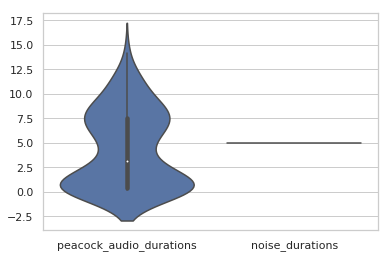

In [13]:
sns.set(style="whitegrid")
ax = sns.violinplot(data=dafr)

In [76]:
fn,features,final_labels,label,label1,label2 = parse_audio_files2(parent_dir,sub_dirs)

iid
Kaan
C_new2
TRIM_old
A_new1
trimmed_new3
noise_set


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Chincholi


Save and Load- Pickle files 

In [0]:
import pickle
def feed_data_to_pkl(fn,db):
  filename = '/content/drive/My Drive/Colab Notebooks/'+fn+'.pkl'
  outfile = open(filename,'wb')
  pickle.dump(db,outfile)
  outfile.close()
  return
def load_data_frm_pkl(fn):
  filename = '/content/drive/My Drive/Colab Notebooks/'+fn+'.pkl'
  infile = open(filename,'rb')
  new_dict = pickle.load(infile)
  infile.close()
  return new_dict

In [0]:
db1 = {}
db2 ={}
db1 = {'filename': fn, 'features': features, 'fin_labels':final_labels, 'label':label,
       'label1':label1,'label2':label2 } 
filename = 'good_data'
feed_data_to_pkl(filename,db1)
#outfile = open(filename,'wb')
#pickle.dump(db1,outfile)
#outfile.close()

In [0]:
new_dict = load_data_frm_pkl('good_data')

In [0]:
fn = new_dict['filename']
features = new_dict['features']
final_labels =new_dict['fin_labels'] 
label = new_dict['label'] 
label1 = new_dict['label1']
label2 = new_dict['label2']

In [0]:
#pd.Series(features).shape

In [0]:
def to_df(fn,label,label1,label2):
  d = pd.DataFrame()
#pd.DataFrame(list(new_dict.items()),columns=['filename', 'features','fin_labels','label','label1','label2'])
  d['filename'] = pd.Series(fn)
  #d['features'] =pd.Series(features)
  #d['fin_labels'] = final_labels
  d['label'] = label
  d['label1'] = label1
  d['label2'] = label2
  return d
d = to_df(fn,label,label1,label2)

In [0]:
d.to_csv('/content/drive/My Drive/Colab Notebooks/data1.csv')

In [84]:
label2.shape

(1272,)

In [50]:
fn_new,features_new,fl_new,label_new,label1_new,label2_new = parse_audio_files2(parent_dir,sub_dirs2)

extra_mp3


In [51]:
print(fl_new.shape)
final_labels.shape

(30, 3)


(1272, 3)

In [0]:
##filename = 'train_feat_labels'
db2={}
db2 = {'filename': fn_new, 'features': features_new, 'fin_labels':fl_new, 'label':label_new,
      'label1':label1_new,'label2':label2_new }
file2 = 'good_data2'
feed_data_to_pkl(file2,db2)

In [56]:
pd.Series(db2['filename']).shape

(30,)

In [0]:
d2 = to_df(fn_new,label_new,label1_new,label2_new)
d2.to_csv('/content/drive/My Drive/Colab Notebooks/data2.csv')

In [0]:
new_dict2 = load_data_frm_pkl('good_data2')
fn_new = new_dict2['filename']
features_new = new_dict2['features']
fl_new =new_dict2['fin_labels'] 
label_new = new_dict2['label'] 
label1_new = new_dict2['label1']
label2_new = new_dict2['label2']

In [85]:
fl_new.shape

(30, 3)

In [0]:
#filename = '/content/drive/My Drive/Colab Notebooks/tr_fea_labels.pkl'
#infile = open(filename,'rb')
#new_dict = pickle.load(infile)
#infile.close()

In [86]:
features.shape

(1272, 193)

In [0]:
#outfile = open(file2,'wb')
#pickle.dump(db2,outfile)
#outfile.close()

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer,LabelBinarizer
from numpy import argmax
from keras.utils import to_categorical
from keras import initializers

one_hot1 = LabelBinarizer()
# One-hot encode data
label_ = one_hot1.fit_transform(label)
label_1 = one_hot1.fit_transform(label1)
#print(one_hot1.classes_)print(label_)print(label_1)
one_hot2 = MultiLabelBinarizer()
# One-hot encode data
#label_2 = one_hot2.fit_transform(label2)
label__2 = to_categorical(label2)
#print(label__2)
#one_hot2.classes_

In [88]:
print(label__2.shape)
print(label_1.shape)
print(label_.shape)
#print(label_2.shape)

(1272, 5)
(1272, 1)
(1272, 1)


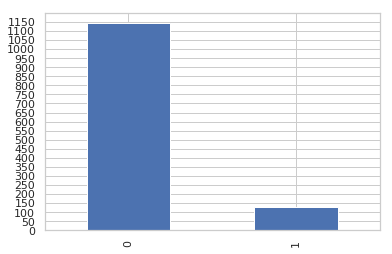

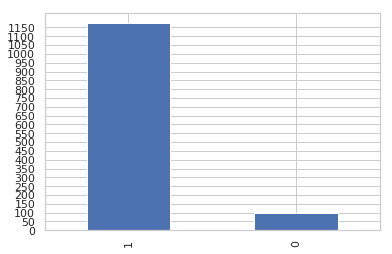

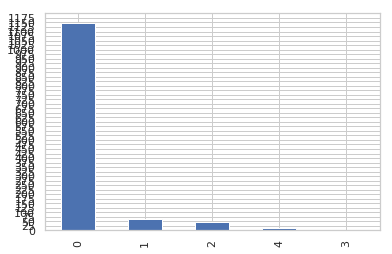

In [89]:
def show_bar_dist_data(d1):
  d1['label'].value_counts().plot(kind='bar')
            #,'disturbance','single_peacock']].plot(kind='bar')
#plt.xticks(np.arange(0, 51, 5)) 
  plt.yticks(np.arange(0, 1200, 50)) 
  plt.show()
  d1['label1'].value_counts().plot(kind='bar')
  plt.yticks(np.arange(0, 1200, 50)) 
  plt.show()
  d1['label2'].value_counts().plot(kind='bar')
  plt.yticks(np.arange(0, 1200, 25)) 
  plt.show()
show_bar_dist_data(d)

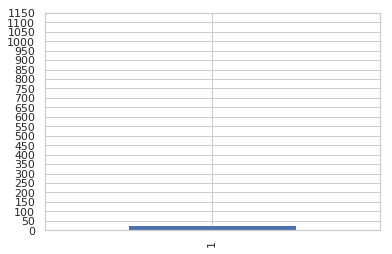

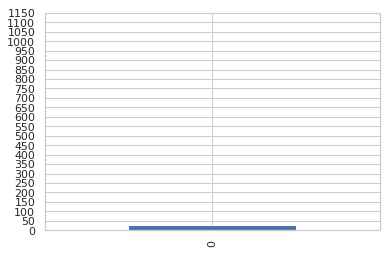

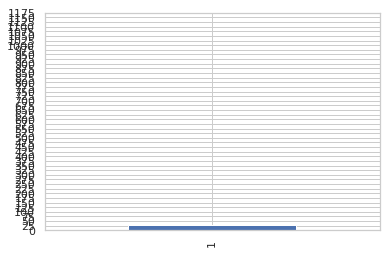

In [64]:
show_bar_dist_data(d2)

In [138]:
pd.Series(pd.Series(label).value_counts())

0    1143
1     129
dtype: int64

In [139]:
pd.Series(pd.Series(label1).value_counts())

1    1174
0      98
dtype: int64

In [0]:
def return_median(gg):
  g=(np.array(gg))
  g.sort()
  n = len(g)
  print(n)  
  if(n%2==0):
    x= (g[int(n/2)]+g[int((n/2) -1)])/2
  else:
    x= g[int((n-1)/2)] 
  return int(x)

In [174]:
print(return_median([1,2,3,4]))

4
2


In [0]:
gg=(pd.Series(pd.Series(label2).value_counts()))

# MLP keras 

In [0]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten, Dropout
from keras.layers.normalization import BatchNormalization

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D
#from keras import regularizers, optimizer
import pandas as pd
import random
import tensorflow as tf
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,multilabel_confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras import backend as K
random.seed(42)
np.random.seed(42)
tf.set_random_seed(42)

#my_init = initializers.glorot_uniform(seed=42)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
#                              inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

In [0]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
import time
from functools import wraps
def timeit(f):
    @wraps(f)
    def wrapper(*args, **kwds):
        start_time = time.time()
        result = f(*args, **kwds)
        elapsed_time = time.time() - start_time
        print('Elapsed computation time: {:.3f} secs'
              .format(elapsed_time))
        return (elapsed_time, result)
    return wrapper

In [0]:
X_train, X_test, y1_train, y1_test,y2_train,y2_test,y3_train,y3_test = train_test_split(features,
                                            label_,label_1,label__2, test_size=0.33, random_state=42)

In [0]:
db_train_test ={}
db_train_test = { 'X_train':X_train,'y1_train':y1_train,'y2_train':y2_train,'y3_train':y3_train,
                 'X_test':X_test,'y1_test':y1_test,'y2_test':y2_test,'y3_test':y3_test}
file_tr_te = 'data_train_test'
feed_data_to_pkl(file_tr_te,db_train_test)
#db_train_test['X_train'] = X_train
#db_train_test['y1_train']=y1_train
#db_train_test['y1_test'] = y1_test
#db_train_test['y2_train'] = y2_train
#db_train_test['y2_test'] =y2_test
#db_train_test['y3_test'] = y3_test
#db_train_test['y3_train'] = y3_train


## Multi output neural network

In [0]:
def make_model(n_dim):
  #create the model
  inn=(Input(shape = (n_dim,)))
  x= (Sequential())(inn)
  # Adding the input layer and the first hidden layer
  x=(Dense(output_dim = 40, init = 'uniform', activation = 'relu', input_dim = 193))(x)
  x=(BatchNormalization())(x)
  x=(Dropout(0.2))(x)
  # Adding the second hidden layer
  x=(Dense(output_dim = 20, init = 'uniform', activation = 'relu'))(x)
  x=(BatchNormalization())(x)
  x=(Dropout(0.2))(x)

  x=(Dense(output_dim = 8, init = 'uniform', activation = 'relu'))(x)
  x=(BatchNormalization())(x)
  x=(Dropout(0.2))(x)
  # Adding the output layer
  out1 =(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))(x)
  out2 =(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))(x)
  out3 =(Dense(output_dim = 5, init = 'uniform', activation = 'softmax'))(x)
  # Compiling Neural Network
  model = Model(inputs=[inn], outputs=[out1, out2,out3])
  #classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  # compile the model
  model.compile(optimizer='adam', loss=['binary_crossentropy','binary_crossentropy','categorical_crossentropy'],
              metrics=[f1_m,f1_m,f1_m])
  return model

In [0]:
def make_model_(n_dim):
  #create the model
  inn=(Input(shape = (n_dim,)))
  x= (Sequential())(inn)
  # Adding the input layer and the first hidden layer
  x=(Dense(output_dim = 40, init = 'uniform', activation = 'relu', input_dim = 193))(x)
  x=(BatchNormalization())(x)
  x=(Dropout(0.2))(x)
  # Adding the second hidden layer
  x=(Dense(output_dim = 20, init = 'uniform', activation = 'relu'))(x)
  x=(BatchNormalization())(x)
  x=(Dropout(0.2))(x)

  x=(Dense(output_dim = 8, init = 'uniform', activation = 'relu'))(x)
  x=(BatchNormalization())(x)
  x=(Dropout(0.2))(x)
  # Adding the output layer
  out1 =(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))(x)
  #out2 =(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))(x)
  #out3 =(Dense(output_dim = 5, init = 'uniform', activation = 'softmax'))(x)
  # Compiling Neural Network
  model = Model(inputs=[inn], outputs=[out1])
  #classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  # compile the model
  #,'binary_crossentropy','categorical_crossentropy'],
  model.compile(optimizer='adam', loss=['binary_crossentropy'],
              metrics=[f1_m])
  return model

In [0]:
def make_model_2(n_dim):
  #create the model
  inn=(Input(shape = (n_dim,)))
  x= (Sequential())(inn)
  # Adding the input layer and the first hidden layer
  x=(Dense(output_dim = 40, init = 'uniform', activation = 'relu', input_dim = 193))(x)
  x=(BatchNormalization())(x)
  x=(Dropout(0.2))(x)
  # Adding the second hidden layer
  x=(Dense(output_dim = 20, init = 'uniform', activation = 'relu'))(x)
  x=(BatchNormalization())(x)
  x=(Dropout(0.2))(x)

  x=(Dense(output_dim = 8, init = 'uniform', activation = 'relu'))(x)
  x=(BatchNormalization())(x)
  x=(Dropout(0.2))(x)
  # Adding the output layer
  #out1 =(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))(x)
  #out2 =(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))(x)
  out3 =(Dense(output_dim = 5, init = 'uniform', activation = 'softmax'))(x)
  # Compiling Neural Network
  model = Model(inputs=[inn], outputs=[out3])
  #classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  # compile the model
  model.compile(optimizer='adam', loss=['categorical_crossentropy'],
              metrics=[f1_m])
  return model

In [1]:
from imblearn.keras import BalancedBatchGenerator
def fit_predict_balanced_model(X_train, y1_train,y2_train,y3_train, X_test, y1_test,y2_test,y3_test):
    model1 = make_model_(X_train.shape[1])
    #print(model.summary())
    training_generator = BalancedBatchGenerator(X_train,y1_train,
                                                batch_size=30,
                                                random_state=42)
    history1 = model1.fit_generator(generator=training_generator,epochs=50, verbose=1)
    yy1= model1.predict(X_test, batch_size=30)
    model2 = make_model_(X_train.shape[1])
    training_generator = BalancedBatchGenerator(X_train,y2_train,
                                                batch_size=30,
                                                random_state=42)
    history2 = model2.fit_generator(generator=training_generator, epochs=50, verbose=1)
    yy2= model2.predict(X_test, batch_size=30)
    model3 = make_model_2(X_train.shape[1])
    training_generator = BalancedBatchGenerator(X_train,y3_train,
                                                            random_state=42)
    history3 = model2.fit_generator(generator=training_generator, epochs=10, verbose=1)
    yy3= model3.predict(X_test)
    return yy1,yy2,yy3,history1,history2,history3,model1,model2,model3

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [194]:
y3_train.shape

(852, 5)

In [2]:
 yy1_b,yy2_b,yy3_b,history1_b,history2_b,history3_b,model1_b,model2_b,model3_b= fit_predict_balanced_model(X_train,
                              y1_train,y2_train,y3_train, X_test, y1_test,y2_test,y3_test)

NameError: ignored

In [0]:
from sklearn.metrics import roc_auc_score
def fit_predict_imbalanced_model(X_train, y1_train,y2_train,y3_train, X_test, y1_test,y2_test,y3_test):
    model = make_model(X_train.shape[1])
    print(model.summary())
    history = model.fit(X_train, [y1_train,y2_train,y3_train],validation_split=0.3,epochs=50, verbose=1, batch_size=30)
    yy1,yy2,yy3 = model.predict(X_test)
    print(yy1.shape)
    print(yy2.shape)
    print(yy3.shape)
    return yy1,yy2,yy3,history,model

Class weights

In [176]:
x1 = pd.Series(pd.Series(label).value_counts())
x2 = pd.Series(pd.Series(label1).value_counts())
x3 = pd.Series(pd.Series(label2).value_counts())
c1=return_median(x1)
c2 = return_median(x2)
c3 =return_median(x3)
class_weights = {0: c3/x3[0],
                1: c3/x3[1],
                2: c3/x3[2],
                3: c3/x3[3],
                4: c3/x3[4]} # w(i) = N/n(i)
cw1 = {0: c1/x1[0],
       1: c1/x1[1]} 
cw2 = {0: c2/x2[0],
       1: c2/x2[1]} 
def fit_predict_weighted_model(X_train, y1_train,y2_train,y3_train, X_test, y1_test,
                               y2_test,y3_test,cw1,cw2,class_weights):
    model = make_model(X_train.shape[1])
    #print(model.summary())
    
    history = model.fit(X_train, [y1_train,y2_train,y3_train],validation_split=0.3,epochs=50, 
                        class_weight=[cw1,cw2,class_weights],verbose=1, batch_size=30)
    yy1,yy2,yy3 = model.predict(X_test)
    print(yy1.shape)
    print(yy2.shape)
    print(yy3.shape)
    return yy1,yy2,yy3,history,model

2
2
5


In [179]:
print(cw1,cw2)
class_weights

{0: 0.5564304461942258, 1: 4.930232558139535} {0: 0.5417376490630323, 1: 6.489795918367347}


{0: 0.041884816753926704, 1: 0.75, 2: 1.0, 3: 4.363636363636363, 4: 16.0}

In [0]:
yy1,yy2,yy3,his_plain,model_plain = fit_predict_imbalanced_model(X_train, y1_train,y2_train,
                                                     y3_train, X_test, y1_test,y2_test,y3_test)

In [0]:
db_plain_res = {}
db_plain_res = {'yy1':yy1,'yy2':yy2,'yy3':yy3,'history':his_plain}
feed_data_to_pkl('plain_res_his',db_plain_res)
feed_data_to_pkl('plain_model',model_plain)

In [181]:
yy1_w,yy2_w,yy3_w,his_w,model_w = fit_predict_weighted_model(X_train, y1_train,y2_train,
                                                     y3_train, X_test, y1_test,y2_test,y3_test,cw1,cw2,class_weights)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=193, units=40, kernel_initializer="uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=20, kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=8, kernel_initializer="uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kern

Train on 596 samples, validate on 256 samples
Epoch 1/50
596/596 [==============================] - 5s 8ms/step - loss: 5.2168 - dense_76_loss: 0.7097 - dense_77_loss: 4.0890 - dense_78_loss: 0.4181 - dense_76_f1_m: 0.1704 - dense_76_f1_m_1: 0.1704 - dense_76_f1_m_2: 0.1704 - dense_77_f1_m: 0.5925 - dense_77_f1_m_1: 0.5925 - dense_77_f1_m_2: 0.5925 - dense_78_f1_m: 0.0000e+00 - dense_78_f1_m_1: 0.0000e+00 - dense_78_f1_m_2: 0.0000e+00 - val_loss: 5.3997 - val_dense_76_loss: 0.6256 - val_dense_77_loss: 4.2097 - val_dense_78_loss: 0.5644 - val_dense_76_f1_m: 0.1784 - val_dense_76_f1_m_1: 0.1784 - val_dense_76_f1_m_2: 0.1784 - val_dense_77_f1_m: 0.6043 - val_dense_77_f1_m_1: 0.6043 - val_dense_77_f1_m_2: 0.6043 - val_dense_78_f1_m: 0.0000e+00 - val_dense_78_f1_m_1: 0.0000e+00 - val_dense_78_f1_m_2: 0.0000e+00
Epoch 2/50
596/596 [==============================] - 0s 212us/step - loss: 5.1239 - dense_76_loss: 0.6921 - dense_77_loss: 4.0183 - dense_78_loss: 0.4136 - dense_76_f1_m: 0.2323 - d

In [0]:
db_wres = {}
db_wres = {'yy1':yy1_w,'yy2':yy2_w,'yy3':yy3_w,'history':his_w}
feed_data_to_pkl('weighted_res_hist',db_wres)
feed_data_to_pkl('weighted_model',model_w)

In [0]:
y3_test_f =[]
y3_train_f = []
for i in range(len(y3_test)):
  y3_test_f.append(np.argmax(y3_test[i]))
for i in range(len(y3_train)):
  y3_train_f.append(np.argmax(y3_train[i])) 
y3_train_f = np.array(y3_train_f)
y3_test_f = np.array(y3_test_f)

In [0]:
yy1_b,yy2_b,yy3_b,his_bal,model_bal = fit_predict_balanced_model(X_train, y1_train.ravel(),y2_train.ravel(),
                                                     y3_train_f, X_test, y1_test.ravel(),y2_test.ravel(),y3_test_f)

In [95]:
print(y3_train.shape)
print(y3_test.shape)

(852, 5)
(420, 5)


In [0]:
# evaluate the model
f1score = model.evaluate(X_test, [y1_test,y2_test,y3_test])
#classifier =KerasClassifier(build_fn=making_model(193), epochs=100, batch_size=10, verbose=0)

410/410 [==============================] - 0s 100us/step


In [0]:
f1score

[0.4752868788998301,
 0.08234787732362747,
 0.10622140020132065,
 0.2854807674884796,
 0.7038729786872864,
 0.9776144623756409,
 0.9295616149902344]

In [0]:
yy1,yy2,yy3 = model.predict(X_test)
def normalise_op(yy1,yy2,yy3):
  shape = yy3.shape
  for i in range(0, shape[0]):
    for j in range(0, shape[1]):
      if yy3[i, j] >= 0.5:
        yy3[i, j] = 1
      else:
        yy3[i, j] = 0
  for i in range(0, shape[0]):
    if yy2[i, 0] >= 0.5:
      yy2[i, 0] = 1
    else:
      yy2[i, 0] = 0
  for i in range(0, shape[0]):
    if yy1[i, 0] >= 0.5:
      yy1[i, 0] = 1
    else:
      yy1[i, 0] = 0  
  return yy1,yy2,yy3
yy1,yy2,yy3 = normalise_op(yy1,yy2,yy3)

In [0]:
res_pred=np.empty(shape=(len(yy3),1),dtype=int)
res_ex = np.empty(shape=(len(yy3),1),dtype=int)

In [0]:
for i in range(len(yy3)):
    res_pred[i] = argmax(yy3[i])
    res_ex[i] = argmax(y3_test[i])
    #print(argmax(yy3[i]))
    #print(y3_test[i])
    #print("--------------------------------------------")

In [0]:
print(confusion_matrix(y1_test,yy1))
print(classification_report(y1_test,yy1))

[[374   1]
 [ 10  25]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       375
           1       0.96      0.71      0.82        35

    accuracy                           0.97       410
   macro avg       0.97      0.86      0.90       410
weighted avg       0.97      0.97      0.97       410



In [0]:
print(confusion_matrix(y2_test,yy2))
print(classification_report(y2_test,yy2))

[[ 14   8]
 [  9 379]]
              precision    recall  f1-score   support

           0       0.61      0.64      0.62        22
           1       0.98      0.98      0.98       388

    accuracy                           0.96       410
   macro avg       0.79      0.81      0.80       410
weighted avg       0.96      0.96      0.96       410



In [0]:
confusion_matrix(res_ex,res_pred)

array([[371,   0,   0,   6,   0],
       [ 13,   0,   0,   0,   0],
       [ 17,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0]])

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 193)          0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 193)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 40)           7760        sequential_1[1][0]               
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 40)           160         dense_1[0][0]                    
____________________________________________________________________________________________

In [0]:
print(f1_score(res_ex,res_pred,average='weighted'))
print(precision_score(res_ex,res_pred,average='weighted'))
print(recall_score(res_ex,res_pred,average='weighted'))

0.8747154471544717
0.8464988198269079
0.9048780487804878


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
print(f1_score(res_ex,res_pred,average='micro'))
print(precision_score(res_ex,res_pred,average='micro'))
print(recall_score(res_ex,res_pred,average='micro'))

0.9048780487804878
0.9048780487804878
0.9048780487804878


In [0]:
accuracy_score(res_ex,res_pred)

0.9048780487804878

In [0]:
print(f1_score(res_ex,res_pred,average='macro'))
print(precision_score(res_ex,res_pred,average='macro'))
print(recall_score(res_ex,res_pred,average='macro'))

0.19025641025641027
0.18411910669975187
0.19681697612732096


In [0]:
from imblearn.keras import BalancedBatchGenerator
from sklearn.metrics import roc_auc_score

def fit_predict_balanced_model(X_train, y_train, X_test, y_test):
    model = classifier
    training_generator = BalancedBatchGenerator(X_train, y_train)
    model.fit_generator(generator=training_generator,epochs=100,verbose=1)
    y_pred = model.predict_proba(X_test)
    print(classification_report(y_test, y_pred))
    return roc_auc_score(y_test, y_pred)
res = fit_predict_balanced_model(X_train, y_train, X_test, y_test)

In [0]:
classifier

In [0]:
model

In [0]:
# Fitting our model 
import eli5
from eli5.sklearn import PermutationImportance

history=model.fit(X_train, y_train,validation_data=(X_test, y_test),nb_epoch = 100)
#history=classifier.fit(X,y,validation_data=(X_test, y_test), batch_size = 10, nb_epoch = 100)
#acc = []
# Predicting the Test set results

In [0]:
# F1 score
f1_score(y_test,y_pred)